In [1]:
#Check if dataset loads

import csv
import os
import numpy as np
import cv2
import keras

DATASET_PATH = "../../data/udacity_sim_data/"

def load_dataset(file_path):
    '''
    Loads dataset in memory
    '''
    dataset = []
    with open(file_path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            try:
                dataset.append({'center':line[0], 'left':line[1], 'right':line[2], 'steering':float(line[3]), 
                            'throttle':float(line[4]), 'brake':float(line[5]), 'speed':float(line[6])})
            except:
                continue
    return dataset

dataset = load_dataset(os.path.join(DATASET_PATH, "driving_log.csv"))
print("Loaded {} samples from file {}".format(len(dataset),DATASET_PATH))

Using TensorFlow backend.


Loaded 45999 samples from file ../../data/udacity_sim_data/



Exploring the dataset ...


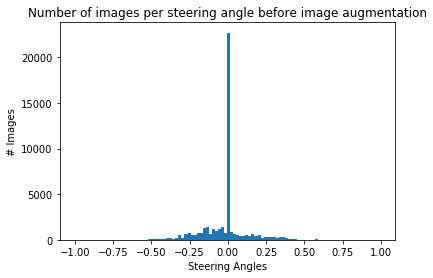

Exploring the dataset complete.


In [2]:
# Plot data distribution

import matplotlib.pyplot as plt
 
print("\nExploring the dataset ...")
 
# It plots the histogram of an arrray of angles: [0.0,0.1, ..., -0.1]
def plot_steering_histogram(steerings, title, num_bins=100):
    plt.hist(steerings, num_bins)
    plt.title(title)
    plt.xlabel('Steering Angles')
    plt.ylabel('# Images')
    plt.show()
 
# It plots the histogram of an arrray of associative arrays of angles: [{'steering':0.1}, {'steering':0.2}, ..., {'steering':-0.1}]
def plot_dataset_histogram(dataset, title, num_bins=100):
    steerings = []
    for item in dataset:
        steerings.append( float(item['steering']) )
    plot_steering_histogram(steerings, title, num_bins)
 
# Plot the histogram of steering angles before the image augmentation
plot_dataset_histogram(dataset, 'Number of images per steering angle before image augmentation', num_bins=100)
print("Exploring the dataset complete.")

In [6]:
# Load CNN model with weights. Cut it till certain layer
# Make the CNN model time distributed
# Load RNN model with weights
# Define new model that combines this two and compile

from keras.models import load_model, Model
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Adam
from tqdm import tqdm

CNN_MODEL_PATH = "../../data/weights/steer_only/model.json"
RNN_MODEL_PATH = "../../data/weights/steer_rnn_best/model.json"

with open(CNN_MODEL_PATH, 'r') as jfile:
    cnn_model = model_from_json(jfile.read())

with open(RNN_MODEL_PATH, 'r') as jfile:
    rnn_model = model_from_json(jfile.read())

cnn_weights = CNN_MODEL_PATH.replace('json', 'h5')
cnn_model.load_weights(cnn_weights)
cnn_model.summary()

rnn_weights = RNN_MODEL_PATH.replace('json', 'h5')
rnn_model.load_weights(rnn_weights)
rnn_model.summary()

cnn_model = Model(input=cnn_model.input, output=cnn_model.get_layer("FC2").output)
rnn_model = Model(input=rnn_model.input, output=rnn_model.get_layer("output").output)

# print(cnn_model.input)
# print(cnn_model.output)
# print(rnn_model.input)
# print(rnn_model.output)

rcnn_model = Sequential()
rcnn_model.add(TimeDistributed(cnn_model, input_shape=(None, 160, 320, 3)))
rcnn_model.add(rnn_model)

adam = Adam(lr=0.0001)
rcnn_model.compile(loss='mean_squared_error', optimizer=adam)

rcnn_model.summary()

print(rcnn_model.input)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 160, 320, 3)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
Conv1 (Convolution2D)            (None, 38, 78, 8)     2912        lambda_2[0][0]                   
____________________________________________________________________________________________________
Conv2 (Convolution2D)            (None, 17, 37, 16)    3216        Conv1[0][0]                      
____________________________________________________________________________________________________
Conv3 (Convolution2D)            (None, 7, 17, 32)     12832       Conv2[0][0]                      
___________________________________________________________________________________________

In [ ]:
### Not using this block of code. Ignore


# Instead of loading CNN model, define new CNN model with same layer names so that weights get loaded
# But while defining new CNN model, add time distribution to each layer

# But currently, names of produced model is not matching with saved model weights

from keras.models import load_model, Model
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Lambda, Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Cropping2D, Convolution2D
from keras.layers.advanced_activations import ELU
from keras.layers.noise import GaussianNoise
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Adam
from tqdm import tqdm

CNN_MODEL_PATH = "../../data/weights/steer_only/model.json"
RNN_MODEL_PATH = "../../data/weights/steer_rnn_best/model.json"

with open(RNN_MODEL_PATH, 'r') as jfile:
    rnn_model = model_from_json(jfile.read())

rnn_weights = RNN_MODEL_PATH.replace('json', 'h5')
rnn_model.load_weights(rnn_weights)
rnn_model.summary()


cnn_model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
cnn_model.add(TimeDistributed(Lambda(lambda x: (x / 127.5) - 1.0), input_shape=(None, 160, 320, 3)))
# Block - conv
cnn_model.add(TimeDistributed(Convolution2D(8, 11, 11, border_mode='valid', subsample=[4,4], init='glorot_uniform', 
                            activation='elu', name='Conv1')))
# Block - conv
cnn_model.add(TimeDistributed(Convolution2D(16, 5, 5, border_mode='valid', subsample=[2,2], init='glorot_uniform', 
                            activation='elu', name='Conv2')))
# Block - conv
cnn_model.add(TimeDistributed(Convolution2D(32, 5, 5, border_mode='valid', subsample=[2,2], init='glorot_uniform', 
                            activation='elu', name='Conv3')))
# Block - conv
cnn_model.add(TimeDistributed(Convolution2D(32, 5, 5, border_mode='valid', subsample=[2,2], init='glorot_uniform', 
                            activation='elu', name='Conv4')))
# Block - flatten
cnn_model.add(TimeDistributed(Flatten()))
cnn_model.add(TimeDistributed(Dropout(0.2)))
cnn_model.add(TimeDistributed(ELU()))
# Block - fully connected
cnn_model.add(TimeDistributed(Dense(256, activation='elu', name='FC1')))
cnn_model.add(TimeDistributed(Dropout(0.2)))
cnn_model.add(TimeDistributed(ELU()))
cnn_model.add(TimeDistributed(Dense(64, activation='elu', name='FC2')))
cnn_model.add(TimeDistributed(ELU()))
# Block - output
cnn_model.add(TimeDistributed(Dense(1, activation='linear', name='output'))) 
cnn_model.summary()

cnn_weights = CNN_MODEL_PATH.replace('json', 'h5')
cnn_model.load_weights(cnn_weights)

cnn_model = Model(input=cnn_model.input, output=cnn_model.get_layer("FC2").output)
rnn_model = Model(input=rnn_model.input, output=rnn_model.get_layer("output").output)

# print(cnn_model.input)
# print(cnn_model.output)
# print(rnn_model.input)
# print(rnn_model.output)

rcnn_model = Sequential()
rcnn_model.add(TimeDistributed(cnn_model, input_shape=(None, 160, 320, 3)))
rcnn_model.add(rnn_model)

adam = Adam(lr=0.0001)
rcnn_model.compile(loss='mean_squared_error', optimizer=adam)

rcnn_model.summary()

print(rcnn_model.input)


In [7]:

from sklearn.model_selection import train_test_split

seq_len = 30
BATCH_SIZE = 40

train_set, test_set = train_test_split(dataset, test_size=0.15)

print("train set has {} elements".format(len(train_set)))
print("test set has {} elements".format(len(test_set)))

def data_generator(dataset, seq_len):
    batch_seq_images = np.zeros((BATCH_SIZE, seq_len, 160, 320 ,3))
    batch_seq_steering_angles = np.zeros((BATCH_SIZE, seq_len, 1))
    
    while 1:
        for i in range(BATCH_SIZE):
            while 1:
                index = np.random.randint(len(dataset))
                if index + seq_len <= len(dataset):
                    seq_steering_angles = []
                    seq_images = []
                    for j in range(index, index + seq_len):
                        seq_steering_angles.append(dataset[j]["steering"])
                        img = cv2.imread(DATASET_PATH + dataset[j]["center"].strip())
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        seq_images.append(img)
                    seq_steering_angles = np.array(seq_steering_angles)
                    seq_images = np.array(seq_images)
                    break
                else:
                    continue
            batch_seq_images[i] = seq_images
            batch_seq_steering_angles[i] = seq_steering_angles.reshape(30, 1)
            #batch_seq_steering_angles[i] = seq_steering_angles

        # for ru
        yield batch_seq_images, batch_seq_steering_angles


train set has 39099 elements
test set has 6900 elements


In [ ]:

test_gen = data_generator(test_set, seq_len)
batch_seq_images, batch_seq_steering_angles = next(test_gen)

waste = rcnn_model.predict(batch_seq_images, batch_size=BATCH_SIZE)

In [8]:
import keras
from keras.callbacks import Callback
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import math

class LifeCycleCallBack(keras.callbacks.Callback):
    
    def on_epoch_begin(self, epoch, logs={}):
        pass
    
    def on_epoch_end(self, epoch, logs={}):
        pass

    def on_batch_begin(self, batch, logs={}):
        pass
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
    def on_train_begin(self, logs={}):
        print('Beginning training')
        self.losses = []
        
    def on_train_end(self, logs={}):
        print('Ending Training')


NUM_EPOCHS = 250
        
lifecycle_callback = LifeCycleCallBack()

tensorboard = keras.callbacks.TensorBoard(log_dir='../../data/logs/steer_cnn_rnn/', histogram_freq=1, 
                                          write_graph=True, write_images=True)

checkpoint = keras.callbacks.ModelCheckpoint("../../data/weights/steer_cnn_rnn/model.h5", monitor='val_loss', verbose=0, 
                                             save_best_only=True, save_weights_only=True, mode='auto', period=1)

train_generator = data_generator(train_set, seq_len)
valid_generator = data_generator(test_set, seq_len)

samples_per_epoch = math.ceil((len(train_set) - seq_len)/(seq_len*BATCH_SIZE))*BATCH_SIZE
nb_val_samples = math.ceil((len(test_set) - seq_len)/(seq_len*BATCH_SIZE))*5*BATCH_SIZE


print("\nSaving Model...")

model_json = rcnn_model.to_json()
with open("../../data/weights/steer_cnn_rnn/model.json", "w") as json_file:
    json_file.write(model_json)

#model.save_weights("model.h5")
print("Model Saved.")


history = rcnn_model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              samples_per_epoch=samples_per_epoch,
                              nb_val_samples=nb_val_samples,
                              nb_epoch=NUM_EPOCHS, verbose=1, 
                              callbacks=[lifecycle_callback, tensorboard, checkpoint])

print("\nTraining the model ended.")




Saving Model...
Model Saved.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names 

Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow 

Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow 

1320/1320 [==============================] - 60s - loss: 0.0108 - val_loss: 0.0126
Epoch 97/250
1320/1320 [==============================] - 60s - loss: 0.0113 - val_loss: 0.0129
Epoch 98/250
1320/1320 [==============================] - 60s - loss: 0.0114 - val_loss: 0.0122
Epoch 99/250
1320/1320 [==============================] - 60s - loss: 0.0112 - val_loss: 0.0125
Epoch 100/250
1320/1320 [==============================] - 60s - loss: 0.0109 - val_loss: 0.0125
Epoch 101/250
1320/1320 [==============================] - 60s - loss: 0.0112 - val_loss: 0.0122
Epoch 102/250
1320/1320 [==============================] - 60s - loss: 0.0110 - val_loss: 0.0123
Epoch 103/250
1320/1320 [==============================] - 60s - loss: 0.0111 - val_loss: 0.0127
Epoch 104/250
1320/1320 [==============================] - 60s - loss: 0.0106 - val_loss: 0.0127
Epoch 105/250
1320/1320 [==============================] - 60s - loss: 0.0111 - val_loss: 0.0125
Epoch 106/250
1320/1320 [======================

dict_keys(['loss', 'val_loss'])


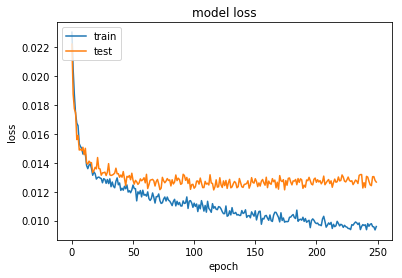

In [9]:
# Plot train and valid loss curve

# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
